In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import PIL
from scipy.io import wavfile
import torchaudio
from IPython.display import Audio, display

In [2]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

# Proyecto 1: Clasificación de Imagenes

De la página [kaggle](https://www.kaggle.com/), descarguen una dataset de clasificación de imagenes. Por ejemplo:
- [dogs and cats dataset](https://www.kaggle.com/chetankv/dogs-cats-images).
- [flowers](https://www.kaggle.com/alxmamaev/flowers-recognition) 
- [pokemon](https://www.kaggle.com/lantian773030/pokemonclassification)
- [American Sign Language](https://www.kaggle.com/grassknoted/asl-alphabet)
- [Rock, Paper, Scissors](https://www.kaggle.com/drgfreeman/rockpaperscissors)

Pueden usar otras plataformas para buscar y descargar los datastes (como google dataset), o tambien pueden crear su propio dataset de las cosas que quisieran classificar (alrededor de 20~50 imagenes por clases estaria bien).

Es necesario que la carpeta que contiene a las imagenes tenga el siguiente formato:
```
dataset/
 clase1/
  puede_haber_subcarpetas/
    imagen1.jpg
    imgen2.jpg
 clase2/
  solo_las_imagenes.jpg
 clase3/
 ....
```

## Reporte

Se usara un el dataset de polemos el cual tiene 25 a 50 imagenes por cada tipo de pokemon, además este tiene 150 tipos de pokemones, los cuales están divididos por carpetas donde cada pokemon esta dentro de  la carpeta con su nombre.

In [4]:
!kaggle datasets download lantian773030/pokemonclassification
!unzip pokemonclassification.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  
  inflating: Pok

In [5]:
# Esto no se necesita modificar. Son las funciones para entrenar el modelo.
# OPTIONAL:
# Si se desea se puede modificar para por ejemplo almacenar el accuracy y el loss de cada epoca para poder plotearlo luego
acc_train = []
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    acc_train.append({train_acc,test_acc})
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

In [6]:
from torchvision.transforms.transforms import RandomGrayscale
# Esto tampoco se necesita modificar.
# OPTIONAL:
# Se puede aumentar más transformaciones (data augmentation) o cambiar el tamaño del resizing.
img_transform = torchvision.transforms.Compose([
  #torchvision.transforms.RandomHorizontalFlip(0.6),
  #torchvision.transforms.RandomVerticalFlip(0.6),
  #torchvision.transforms.RandomRotation(degrees=(0,180)),
  #torchvision.transforms.RandomPerspective(distortion_scale=0.6,p=0.6),
  #torchvision.transforms.RandomGrayscale(0.6),
  torchvision.transforms.Resize((224,224)),
  torchvision.transforms.ToTensor()
])

Tratamos las iamgenes para generar mas data , para ello usamos el transform de pytorch tomando en cuenta que a todos las imagenes para generar la carpeta dataset haciendo un suffle sobre las imagnes creadas y grudarlos ne los respectivos directorios

<Figure size 7200x432 with 0 Axes>

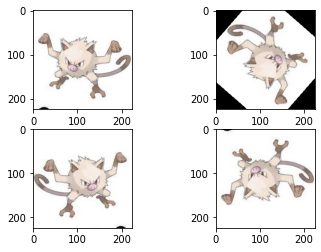

In [7]:
import os
from PIL import Image
pokemones = os.listdir('./PokemonData')
path = './PokemonData/'+pokemones[0]
imgs = os.listdir(path)

im = Image.open(path+'/'+imgs[0])
plt.figure(figsize=(100,6))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

resizeImg = torchvision.transforms.Resize((224,224))
im = resizeImg(im)
ax1.imshow(im)
rotater = torchvision.transforms.RandomRotation(degrees=(0,180))
rot_img = rotater(im)
ax2.imshow(rot_img)
hor = torchvision.transforms.RandomHorizontalFlip(p=1.0)
im3 = hor(im)
ax3.imshow(im3)
ver = torchvision.transforms.RandomVerticalFlip(p=1.0)
im4 = ver(im)
ax4.imshow(im4)

Creando los directorios

In [8]:
try:
  os.mkdir('dataset')
except OSError:
  print("Error en la creación del directorio")
try:
  os.mkdir('dataset/test_set')
except OSError:
  print("Error en la creación del directorio")
try:
  os.mkdir('dataset/train_set')
except OSError:
  print("Error en la creación del directorio")
for pokemon in pokemones:
  try:
    os.mkdir('dataset/train_set/'+pokemon)
    os.mkdir('dataset/test_set/'+pokemon)
  except OSError:
    print("Error creando directorio de",pokemon)

Instalando un lector de svg, pues algunas imagnes en el dataset existe iamgenes svg los cuales PIL no puede leer 

In [9]:
!pip install cairosvg

     |████████████████████████████████| 45 kB 2.7 MB/s 
     |████████████████████████████████| 88 kB 7.3 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=a434e73687225423b54a436633712799587313ba8605b94677114c0d679a782d
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [10]:
from cairosvg import svg2png
from io import BytesIO

def svg2img2(ruta):
  svg_data = open(ruta,'r')
  linea = ''
  for l in svg_data:
    linea += l
  png = svg2png(bytestring=linea)
  pil_img = Image.open(BytesIO(png))
  return pil_img

Creando un dataset con data aumentada para tener mas datos de entrenamiento, los cuales son un resize par ocupar menos espacio en el colab, una rotacion, un flip vertical y un flip horizontal.

In [11]:
import math
import re
trainPath = './dataset/train_set'
testPath = './dataset/test_set'

for pokemon in pokemones:
  path = './PokemonData/'+pokemon
  imgs = os.listdir(path)
  newImgs = []
  for img in imgs:
    try:
      oimg = Image.open(path+'/'+img)
    except:
      match_svg = re.search('.+\.svg',img)
      if match_svg:
        oimg = svg2img2(path+'/'+img)
      else:
        print("No se puedo abrir",path+'/'+img)
    im = resizeImg(oimg)
    newImgs.append(im)
    #imr = hor(im)
    #newImgs.append(imr)
  np.random.shuffle(newImgs)
  n = len(newImgs)
  part = math.floor(0.9*n)
  j=0
  #plt.imshow(newImgs[0])
  for img in newImgs:
    path = trainPath if j<part else testPath
    path += '/'+ pokemon
    
    #k = len(os.listdir(path))
    img.save(path+'/'+pokemon+str(j)+'.png')
    j+=1 

Se coloca los el dataset respectivo en el train y en el test, pero al momento de entrenar vimos con la data aumentada este tenia un 50% de test acc y un 95% de tran acc por lo cuan se decidio solo tomar en cuenta la data sin tratar

In [12]:
# TODO: Modificar el path en donde se encuentrar sus imagenes de training y testing
train_ds = torchvision.datasets.ImageFolder("./PokemonData",transform=img_transform)
test_ds = torchvision.datasets.ImageFolder("./PokemonData",transform=img_transform)
#train_ds = torchvision.datasets.ImageFolder("./dataset/train_set",transform=img_transform)
#test_ds = torchvision.datasets.ImageFolder("./dataset/test_set",transform=img_transform)

In [13]:
# Esto no se necesita modificar al menos que se quiera utilizar un batch size diferente
# OPTIONAL:
# Cambiar la opción de shuffle a False y observar que pasa con los input y targets que nos brinda el dataloader, que diferencias hay?
# Observar que pasa con el accuracy cuando no se realiza el shuffling y explicar porque.

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128,shuffle=True)

Creamos nuesta capa resnet con las convuluciines batch norm y funcines de activación uniendo las entrada con las salidas para evitar la perdida de los gradientes.

In [14]:
class BasicResBlock(nn.Module):
  def __init__(self,in_planes, out_planes, kernel_size=3, stride=1,padding=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,stride=stride,padding=padding,bias=False)
    self.bn1 = nn.BatchNorm2d(out_planes)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=kernel_size,stride=1,padding=padding,bias=False)
    self.bn2 = nn.BatchNorm2d(out_planes)
    self.relu2 = nn.ReLU()
    self.shortcut = nn.Sequential()
    if stride > 1 or in_planes != out_planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes,out_planes,kernel_size=1,stride=stride,padding=0,bias=False),
          nn.BatchNorm2d(out_planes)
      )
  def forward(self,x):
    o = self.conv1(x)
    o = self.bn1(o)
    o = self.relu1(o)
    o = self.conv2(o)
    o = self.bn2(o)
    o = self.relu2(self.shortcut(x) + o)
    return o

Usamos lo anterior para crear nuestro modelo, y terminamos con una capa lineal para clasificar los patronos que nuestra resNet obtuvo.

In [15]:
modelRes = nn.Sequential(
    BasicResBlock(3,16),
    nn.MaxPool2d(kernel_size=3),
    BasicResBlock(16,32),
    nn.MaxPool2d(kernel_size=3),
    BasicResBlock(32,64),
    nn.MaxPool2d(kernel_size=3),
    BasicResBlock(64,128),
    nn.MaxPool2d(kernel_size=3),
    nn.Flatten(),
    #nn.Linear(512,256),
    #nn.ReLU(inplace=True),
    nn.Linear(512,150)
).to(dev)

In [16]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(modelRes.parameters(),lr=0.1)
train(modelRes,train_dl, test_dl, crit, optim, epochs=10)

epoch: 0, train loss: 4.0272000939757735, train acc: 11.422287390029325%, test loss: 4.082521866869043, test acc: 7.712609970674487%
epoch: 1, train loss: 2.50149166142499, train acc: 35.02932551319648%, test loss: 4.851030491016529, test acc: 16.158357771261%
epoch: 2, train loss: 1.7281695891309667, train acc: 54.20821114369502%, test loss: 2.677960656307362, test acc: 33.47507331378299%
epoch: 3, train loss: 1.292049585669129, train acc: 65.60117302052785%, test loss: 1.8081879836541634, test acc: 50.219941348973606%
epoch: 4, train loss: 0.9737628312022598, train acc: 74.10557184750733%, test loss: 2.562869328039664, test acc: 34.32551319648094%
epoch: 5, train loss: 0.7301290570585816, train acc: 80.79178885630499%, test loss: 1.8467154679475006, test acc: 50.483870967741936%
epoch: 6, train loss: 0.5359024935298495, train acc: 86.0117302052786%, test loss: 1.3182644446690877, test acc: 61.09970674486804%
epoch: 7, train loss: 0.3595925762697502, train acc: 91.56891495601172%, tes

In [ ]:
import os
cont = os.listdir('./PokemonData')
cont = sorted(cont)  

3


'Alolan Sandslash'

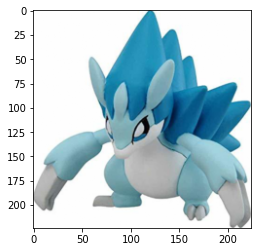

In [18]:
modelRes.eval()
# idx = 10
idx = 1000
x, y = test_ds[120]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(modelRes(x.to(dev)).cpu()).item()
print(pred)
plt.imshow(x_numpy)
cont[pred]

In [19]:
torch.save(modelRes.state_dict(),"proyectoRes.ckpt")

Usando el modelo para predecir 8 imagenes

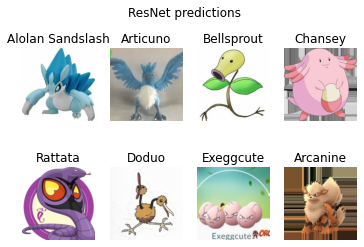

In [22]:
import math
def imagenEval(id):

  modelRes.eval()
  x, y = test_ds[id]
  x_numpy = x.numpy().transpose(1,2,0)
  N, H, W = x.shape
  x = x.reshape(1,N,H,W)
  pred = torch.argmax(modelRes(x.to(dev)).cpu()).item()
  return x_numpy, pred

ids =[120,240,300,500,140,1000,1400,200]
fig, (r) = plt.subplots(2,4) 
fig.suptitle('ResNet predictions')
for i in range(len(ids)):
  ax = r[math.floor(i/4)][i%4]
  im,pred = imagenEval(ids[i])
  ax.imshow(im)
  ax.set_title(cont[pred])
  ax.axis('off')
plt.show()

Ploteamos es acc del test y train al momento de entrenar nuestro modelo

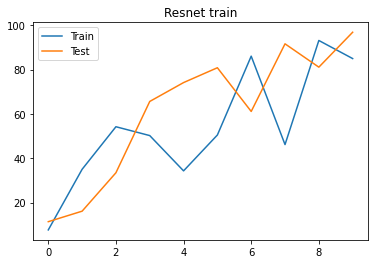

In [21]:
array_train=[]
array_test= []
for i in acc_train:
  test,train = list(i)
  array_train.append(train)
  array_test.append(test)
abcisa = np.arange(10)
plt.plot(abcisa,array_train,label="Train")
plt.plot(abcisa,array_test,label="Test")
plt.legend(loc = "upper left")
plt.title("Resnet train")
plt.show()